## Prep: Database Connection

In [1]:
import pandas as pd

In [2]:
from configparser import ConfigParser
from sqlalchemy.engine.url import make_url

import cx_ora_fix; cx_ora_fix.patch_version()  # noqa: E702

def _sgrouse(cfg='luigi-gd.cfg'):
    from os import environ
    from getpass import getpass
    from pathlib import Path
    from sqlalchemy import create_engine
    cp = ConfigParser()
    cp.read_file(Path(cfg).open(), str(cfg))
    acct = make_url(cp.get('ETLAccount', 'account'))
    # print(acct)
    host, port = cp.get('ETLAccount', 'ssh_tunnel').split(':')
    acct.host = host
    acct.port = int(port)
    #acct.password = environ[cp.get('ETLAccount', 'passkey')]
    acct.password = getpass()
    return create_engine(acct)

db = _sgrouse()
db.execute('select * from global_name').fetchone()

········


('SGROUSE.KUMC.EDU',)

## Encounters

In [5]:
enc = pd.read_sql('select * from encounters_by_site_yr_type', db)
enc.head()

,site,has_claims,year,enc_type,encounters,pct,patients,encounters_per_patient
0,KUMC,0,2010,AV/ED/IS/OS,247250,56.2,76913,3.2
1,KUMC,0,2010,IP/EI,9022,2.0,6410,1.4
2,KUMC,0,2010,Other,184060,41.8,46198,4.0
3,KUMC,0,2011,AV/ED/IS/OS,433276,52.6,119807,3.6
4,KUMC,0,2011,IP/EI,13981,1.7,10105,1.4


In [6]:
enc.enc_type.unique()

array(['AV/ED/IS/OS', 'IP/EI', 'Other'], dtype=object)

In [19]:
enc01 = enc[(enc.year >= 2011) & (enc.year <= 2016)].groupby('has_claims')

encp01 = {}
for has_claims, df in enc01:
    encp01[has_claims] = df.pivot_table(index=['enc_type', 'year'], columns=['has_claims', 'site'])[['patients', 'encounters_per_patient']]

In [20]:
enc_ss = pd.ExcelWriter('enc_by_yr.xlsx')

## Encounters by Year, Site, with claims

In [21]:
encp01[1].to_excel(enc_ss, 'With Claims')
encp01[1]

patients                                               \
has_claims              1                                                
site                 KUMC    MCRF     MCW     MU  UIOWA   UNMC    UTSW   
enc_type    year                                                         
AV/ED/IS/OS 2011    65009  170708   91337  40772  52911  16213  171310   
            2012    67446  171764  112340  53627  53902  50431  168273   
            2013    70333  165894  121467  51778  51510  54354  156898   
            2014    70002  160236  128243  49557  50294  56820  102015   
            2015    69557  152289  129198  44468  51435  63808   66039   
            2016    64808  141677  122518  38761  51019  72281   60183   
IP/EI       2011     9962   18775    2608   5200   8075   1772   22436   
            2012     9561   19292   15658   8323   8533  14358   23878   
            2013     8691   18610   18228   8074   8281  16619   20157   
            2014     8537   17474   19083   8211   8463  17202   10603   
            2015     8675   15861   18622   6863   8739  17563    7806   
            2016     8144   14295   17633   5459   8429  16829    7208   
Other       2011    51061  162863  136346   6620  39628   9126  143147   
            2012    63876  138691  138176  11555  40833  26764  128387   
            2013    72437  124123  145061  12490  40650  27088  136007   
            2014    85160  119448  147280  13234  47197  27838  158904   
            2015    85046  113105  147930  14099  49084  30523  159350   
            2016    72477  108158  138569  13588  45573  37160  165626   

                 encounters_per_patient                                    
has_claims                            1                                    
site                               KUMC  MCRF   MCW   MU UIOWA UNMC  UTSW  
enc_type    year                                                           
AV/ED/IS/OS 2011                    5.0  13.8   6.6  6.3   6.7  2.3  12.2  
            2012                    4.9  14.0   7.7  9.4   6.6  3.9  11.4  
            2013                    4.9  14.0   8.4  7.6   6.7  4.2  11.6  
            2014                    5.4  14.0   8.7  6.5   5.8  4.2  10.9  
            2015                    5.6  14.4   8.9  6.9   5.5  4.1  14.3  
            2016                    5.9  14.5   9.2  6.8   5.5  4.3  15.1  
IP/EI       2011                    1.6  14.0   1.2  1.4   1.5  1.3   2.4  
            2012                    1.6  14.8   1.5  1.5   1.4  1.6   2.7  
            2013                    1.6  14.5   1.5  1.5   1.4  1.6   2.6  
            2014                    1.6  14.4   1.5  1.4   1.4  1.6   2.2  
            2015                    1.5  13.6   1.5  1.5   1.4  1.7   2.2  
            2016                    1.5  13.4   1.5  1.5   1.4  1.7   2.3  
Other       2011                    7.7  12.1  20.0  2.0   5.9  3.0   9.9  
            2012                    8.1   7.9  20.6  2.5   6.0  5.0  11.2  
            2013                    9.6   7.6  19.8  2.4   6.3  5.0  11.3  
            2014                   12.1   7.8  20.1  2.3   6.2  4.9  12.1  
            2015                   14.5   7.8  20.6  2.5   7.0  4.7  13.4  
            2016                   17.8   7.2  22.4  2.5   7.9  4.7  13.4

## Encounters by Year, Site, without claims

In [22]:
encp01[0].to_excel(enc_ss, 'Without Claims')
encp01[0]

patients                                                    \
has_claims               0                                                     
site                  KUMC      MCRF       MCW        MU     UIOWA      UNMC   
enc_type    year                                                               
AV/ED/IS/OS 2011  119807.0  238111.0  110344.0   61037.0  182624.0    1606.0   
            2012  138799.0  263080.0  132249.0  120425.0  188320.0   63616.0   
            2013  154541.0  270899.0  162181.0  136149.0  197114.0   92204.0   
            2014  172570.0  277241.0  183736.0  132680.0  198171.0  100970.0   
            2015  189814.0  279290.0  197558.0  144533.0  209832.0  119039.0   
            2016  212154.0  271100.0  211097.0  155909.0  223729.0  164145.0   
IP/EI       2011   10105.0   12096.0       NaN    2555.0   15800.0      48.0   
            2012   12501.0   12544.0    6388.0   10646.0   15692.0    7888.0   
            2013   13735.0   12424.0   13649.0   11585.0   15969.0   18130.0   
            2014   14442.0   12474.0   15704.0   11313.0   16834.0   19897.0   
            2015   17737.0   11974.0   17025.0   12087.0   17892.0   22659.0   
            2016   21403.0   11656.0   17914.0   15036.0   19022.0   25618.0   
Other       2011   80174.0  200444.0  169219.0   18632.0  127793.0    1146.0   
            2012  114759.0  171456.0  182411.0   34361.0  140087.0   25706.0   
            2013  187530.0  149300.0  193844.0   33328.0  142999.0   32839.0   
            2014  250899.0  155432.0  227674.0   27255.0  162740.0   33567.0   
            2015  264378.0  156145.0  234536.0   41357.0  233572.0   40040.0   
            2016  229889.0  158176.0  259288.0   51845.0  202599.0   57606.0   

                           encounters_per_patient                             \
has_claims                                      0                              
site                  UTSW                   KUMC MCRF   MCW   MU UIOWA UNMC   
enc_type    year                                                               
AV/ED/IS/OS 2011  464000.0                    3.6  6.9   4.3  2.9   4.5  2.1   
            2012  513461.0                    3.7  6.7   4.6  5.2   4.6  2.2   
            2013  538315.0                    3.8  6.8   5.1  5.2   4.7  2.7   
            2014  348702.0                    4.0  6.9   5.4  3.9   4.5  2.8   
            2015  161935.0                    4.2  7.0   5.6  4.2   4.1  2.8   
            2016  180697.0                    4.4  7.2   5.7  4.2   4.1  2.6   
IP/EI       2011   48393.0                    1.4  8.9   NaN  1.1   1.3  1.3   
            2012   65297.0                    1.4  8.8   1.2  1.3   1.4  1.2   
            2013   66105.0                    1.4  8.7   1.2  1.3   1.4  1.3   
            2014   28794.0                    1.4  8.9   1.2  1.3   1.3  1.4   
            2015   12853.0                    1.4  8.9   1.2  1.3   1.3  1.4   
            2016   15181.0                    1.4  8.4   1.2  1.2   1.3  1.4   
Other       2011  337560.0                    4.7  6.2   9.8  2.0   3.7  1.6   
            2012  327575.0                    5.1  4.2  10.4  2.8   4.0  2.6   
            2013  392790.0                    4.8  3.8  10.9  2.3   3.8  3.4   
            2014  571772.0                    5.9  4.0  10.7  2.1   4.2  3.4   
            2015  730464.0                    8.5  4.0  11.0  2.1   4.2  3.3   
            2016  946401.0                   11.0  3.9  11.4  2.2   5.2  3.2   

                       
has_claims             
site             UTSW  
enc_type    year       
AV/ED/IS/OS 2011  6.7  
            2012  6.3  
            2013  6.6  
            2014  5.9  
            2015  7.8  
            2016  8.4  
IP/EI       2011  1.6  
            2012  2.0  
            2013  2.2  
            2014  2.2  
            2015  1.7  
            2016  1.8  
Other       2011  4.7  
            2012  5.2  
            2013  5.6  
            2014  5.9  
            2015

In [23]:
enc_ss.save()

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

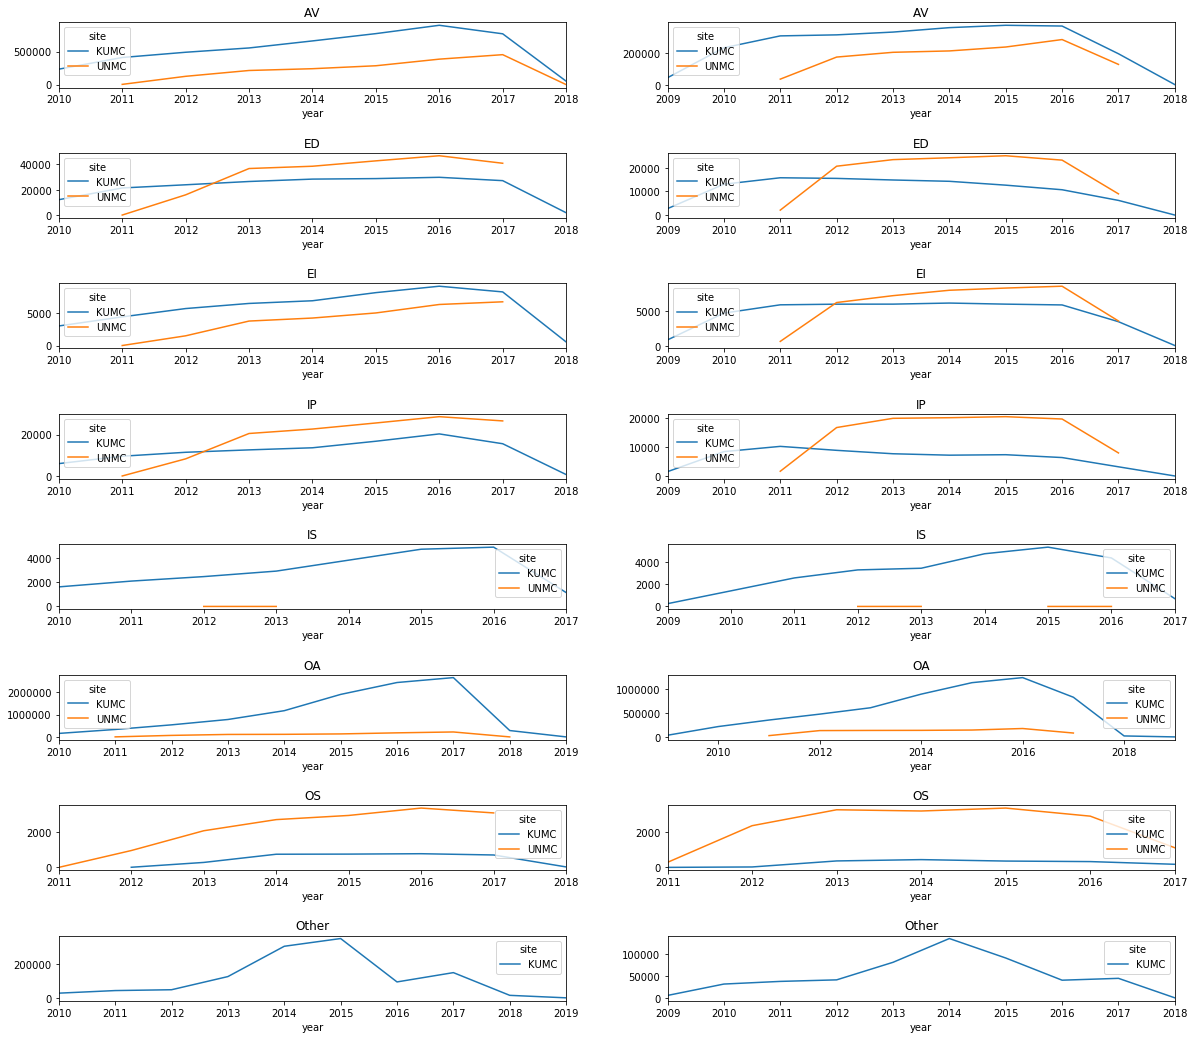

In [160]:
fig, axes = plt.subplots(len(enc.enc_type.unique()), len(enc.has_claims.unique()))

fig.set_figheight(18)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=1)
for ax, col in zip(axes[0], enc.has_claims.unique()):
    ax.set_title(col)

for col, (has_claims, df1) in enumerate(enc.groupby('has_claims')):
    for row, (enc_type, df2) in enumerate(df1.groupby('enc_type')):
        df3 = df2.pivot(index='year', columns='site')
        df3.encounters.plot(ax=axes[row, col], title=enc_type)
        #axes[row, col].plot(x=df3.index, y=df3.loc(site='KUMC').patients, s=df3.encounters_per_patient, marker='x')
        
        # df3.encounters.plot.scatter(ax=axes[row, col], title=enc_type, marker='x')


## Demographics

In [3]:
demo = pd.read_sql('select * from grouse_cms_demo_11_16 sample(1)', db, index_col='patient_num')
demo.head()

,birth_dt,death_dt,sex_mf
patient_num,,,
198347,1963-05-06,NaT,M
3226599,1938-01-10,NaT,F
5281391,1964-06-02,2013-08-06,M
14789652,1936-01-12,NaT,F
3852745,1927-06-12,NaT,M


In [4]:
demo['sex'] = demo.sex_mf.astype('category')
demo.drop('sex_mf', axis=1, inplace=True)
demo.dtypes

birth_dt    datetime64[ns]
death_dt    datetime64[ns]
sex               category
dtype: object

In [5]:
def _now():
    import datetime
    return pd.Timestamp(datetime.datetime.now())

demo['age'] = (demo.death_dt.fillna(_now()) - demo.birth_dt).astype('timedelta64[Y]')
demo.head()

,birth_dt,death_dt,sex,age
patient_num,,,,
198347,1963-05-06,NaT,M,55.0
3226599,1938-01-10,NaT,F,80.0
5281391,1964-06-02,2013-08-06,M,49.0
14789652,1936-01-12,NaT,F,82.0
3852745,1927-06-12,NaT,M,91.0


In [6]:
demo[~demo.death_dt.isnull()].head()

,birth_dt,death_dt,sex,age
patient_num,,,,
5281391,1964-06-02,2013-08-06,M,49.0
279631,1925-01-20,2013-03-05,M,88.0
137557,1941-10-25,2013-01-24,F,71.0
2995400,1925-09-04,2015-06-18,M,89.0
625609,1926-10-16,2012-12-30,F,86.0


In [7]:
data = pd.read_sql('select * from grouse_sets', db)
data.feature = data.feature.astype('category')
data.source = data.source.astype('category')
data = data.set_index(['patient_num', 'feature'])
data.head()

,,scalar,source
patient_num,feature,,
3309389.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
19464371.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
3305908.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
18626002.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY
14853388.0,BENE_ENROLLMT_REF_YR,2012,CMS_DEID.MBSF_AB_SUMMARY


In [62]:
#data = data.reset_index()
#data = data[~data.patient_num.isnull()]
data.patient_num = data.patient_num.astype('int')
data = data[['patient_num', 'feature', 'scalar']]
data.head()

,patient_num,feature,scalar
0,3309389,BENE_ENROLLMT_REF_YR,2012
1,19464371,BENE_ENROLLMT_REF_YR,2012
2,3305908,BENE_ENROLLMT_REF_YR,2012
3,18626002,BENE_ENROLLMT_REF_YR,2012
4,14853388,BENE_ENROLLMT_REF_YR,2012


In [63]:
data.dtypes

patient_num       int64
feature        category
scalar            int64
dtype: object

## Age Distribution

In [49]:
demo.age.describe()

count    2.476513e+07
mean     4.965816e+01
std      2.861240e+01
min     -5.700000e+01
25%      2.000000e+01
50%      5.700000e+01
75%      7.500000e+01
max      1.010000e+02
Name: age, dtype: float64

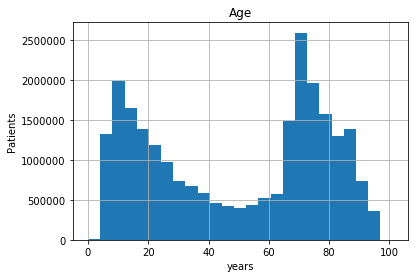

In [65]:
%matplotlib inline

def age_plot(age,
             bins=25, title='Age'):
    plot = age[age >= 0].hist(bins=bins)
    plot.set_title(title)
    plot.set_xlabel('years')
    plot.set_ylabel('Patients')
    plot

age_plot(demo.age);

In [72]:
data.groupby('feature').count()

,patient_num,scalar
feature,,
BENE_ENROLLMT_REF_YR,36750895,36750895
EXTRACT_DT,23865193,23865193


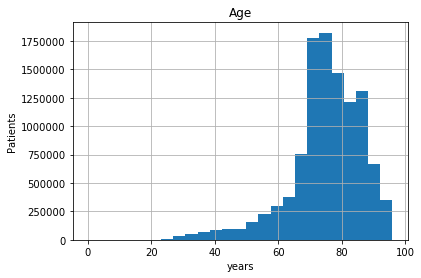

In [68]:
medicare_yr = data[data.feature == 'BENE_ENROLLMT_REF_YR']

age_plot(demo[demo.index.isin(medicare_yr.patient_num)].age)

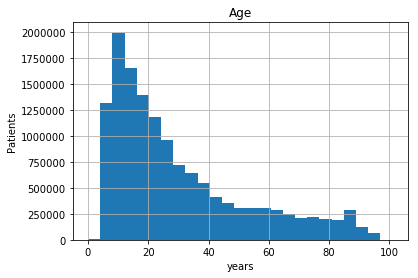

In [77]:
medicaid_yr = data[data.feature == 'EXTRACT_DT          ']

age_plot(demo[demo.index.isin(medicaid_yr.patient_num)].age)